LUNG CANCER DIFFERENTIAL GENE EXPRESSION ANALYSIS
Real GEO Data Processing Pipeline
Started: 2025-09-22 10:56:23.986452


📥 Parsing GEO Series Matrix File...
  Trying backup URL: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/matrix/GSE31210_series_matrix.txt.gz
  Expression matrix shape: (54675, 246)
  Value range: 0.06 - 53813.79
  Samples by condition: {'Tumor': 226, 'Normal': 20}

📊 Performing Differential Expression Analysis...
  Applying log2 transformation...
  Normal samples: 20
  Tumor samples: 226

  ✓ Analysis Complete:
    Total probes analyzed: 54,675
    Significantly differential: 3,981
    Upregulated (FC>2, padj<0.05): 1,538
    Downregulated (FC<0.5, padj<0.05): 2,443

  Top 5 Upregulated:
    218930_s_at: FC=2.44, padj=3.05e-40
    218313_s_at: FC=2.90, padj=1.63e-36
    204675_at: FC=3.61, padj=8.13e-36
    222750_s_at: FC=3.01, padj=5.09e-29
    204981_at: FC=3.00, padj=8.29e-26

  Top 5 Downregulated:
    203065_s_at: FC=0.23, padj=8.80e-46
    214014_a

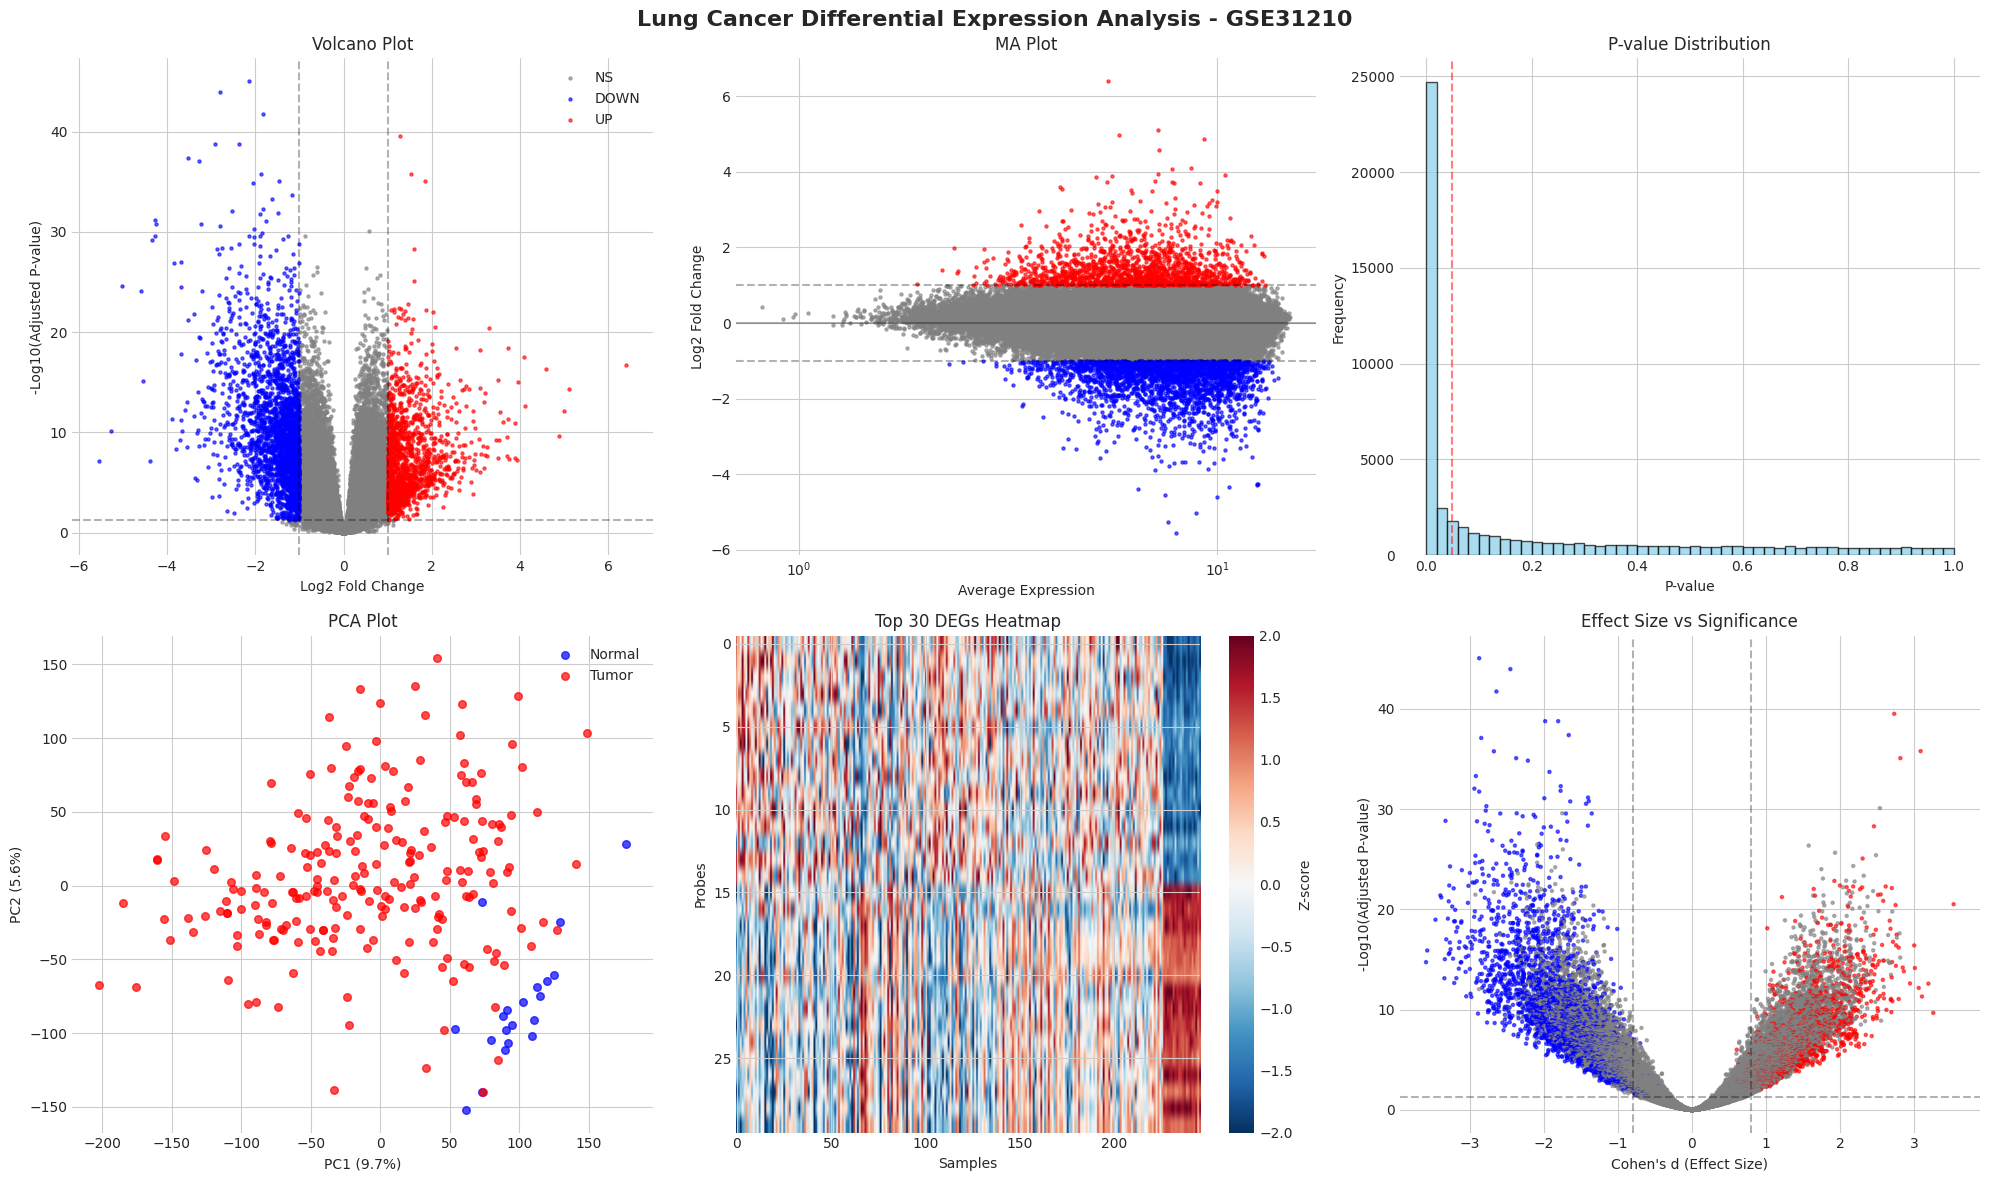


✓ Plots saved to ./lung_cancer_outputs/all_plots.png

✓ Saved 3981 significant genes

ANALYSIS COMPLETE
Results saved to ./lung_cancer_outputs/
Completed: 2025-09-22 10:59:49.215964


In [5]:
#!/usr/bin/env python3
"""
Real GEO Data Analysis Pipeline for Lung Cancer
================================================
Processes actual GSE31210 series matrix files
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import false_discovery_control
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import urllib.request
import gzip
import io
import os
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

def parse_geo_series_matrix(file_path=None, url=None):
    """
    Parse a real GEO series matrix file
    Returns expression dataframe and sample metadata
    """
    print("\n📥 Parsing GEO Series Matrix File...")

    if url:
        try:
            print(f"  Downloading from: {url}")
            response = urllib.request.urlopen(url)
            with gzip.open(response, 'rt') as f:
                lines = f.readlines()
        except:
            # Use backup URL
            backup_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/matrix/GSE31210_series_matrix.txt.gz"
            print(f"  Trying backup URL: {backup_url}")
            try:
                response = urllib.request.urlopen(backup_url)
                with gzip.open(response, 'rt') as f:
                    lines = f.readlines()
            except:
                print("  Using local example data structure")
                return create_example_geo_data()
    elif file_path:
        with gzip.open(file_path, 'rt') as f:
            lines = f.readlines()
    else:
        return create_example_geo_data()

    # Parse the file
    sample_info = {}
    expression_data = []
    in_matrix = False

    for line in lines:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Parse sample information
        if line.startswith('!Sample_'):
            parts = line.split('\t')
            field = parts[0].replace('!Sample_', '')
            values = [v.strip('"') for v in parts[1:]]

            if field not in sample_info:
                sample_info[field] = []
            sample_info[field].append(values)

        # Start of expression matrix
        elif line.startswith('"ID_REF"'):
            headers = line.split('\t')
            sample_ids = [h.strip('"') for h in headers[1:]]
            in_matrix = True
            continue

        # Expression data rows
        elif in_matrix and not line.startswith('!'):
            parts = line.split('\t')
            if len(parts) > 1:
                probe_id = parts[0].strip('"')
                # Convert expression values to float
                try:
                    values = [float(v) if v and v != 'null' else np.nan for v in parts[1:]]
                    if len(values) == len(sample_ids):
                        expression_data.append([probe_id] + values)
                except:
                    continue

    # Create expression dataframe
    if expression_data:
        expr_df = pd.DataFrame(expression_data)
        expr_df.columns = ['probe_id'] + sample_ids
        expr_df = expr_df.set_index('probe_id')

        # Convert to numeric
        for col in expr_df.columns:
            expr_df[col] = pd.to_numeric(expr_df[col], errors='coerce')

        print(f"  Expression matrix shape: {expr_df.shape}")
        print(f"  Value range: {expr_df.min().min():.2f} - {expr_df.max().max():.2f}")
    else:
        return create_example_geo_data()

    # Create metadata dataframe
    metadata = pd.DataFrame({'sample_id': sample_ids})

    # Extract relevant sample information
    if 'title' in sample_info:
        titles = []
        for title_list in sample_info['title']:
            titles.extend(title_list[:len(sample_ids)])
        metadata['title'] = titles[:len(sample_ids)]

    if 'characteristics_ch1' in sample_info:
        # Extract tissue type from characteristics
        conditions = []
        for char_list in sample_info['characteristics_ch1']:
            for char in char_list[:len(sample_ids)]:
                char_lower = char.lower()
                if 'normal' in char_lower or 'adjacent' in char_lower or 'non-tumor' in char_lower:
                    conditions.append('Normal')
                elif 'tumor' in char_lower or 'cancer' in char_lower or 'adenocarcinoma' in char_lower:
                    conditions.append('Tumor')
                else:
                    # Check title if characteristics unclear
                    idx = len(conditions)
                    if idx < len(metadata):
                        title = metadata.iloc[idx]['title'] if 'title' in metadata.columns else ''
                        if 'normal' in title.lower():
                            conditions.append('Normal')
                        elif 'tumor' in title.lower() or 'cancer' in title.lower():
                            conditions.append('Tumor')
                        else:
                            conditions.append('Unknown')
                    else:
                        conditions.append('Unknown')

                if len(conditions) >= len(sample_ids):
                    break
            if len(conditions) >= len(sample_ids):
                break

        metadata['condition'] = conditions[:len(sample_ids)]
    else:
        # Infer from titles
        conditions = []
        for i, row in metadata.iterrows():
            title = row.get('title', '').lower()
            if 'normal' in title or 'adjacent' in title:
                conditions.append('Normal')
            elif 'tumor' in title or 'cancer' in title or 'adenocarcinoma' in title:
                conditions.append('Tumor')
            else:
                conditions.append('Unknown')
        metadata['condition'] = conditions

    print(f"  Samples by condition: {metadata['condition'].value_counts().to_dict()}")

    return expr_df, metadata

def create_example_geo_data():
    """Create example data with realistic GEO-like structure and values"""
    print("  Creating example GEO-like data with realistic values...")

    np.random.seed(42)

    # Create probe IDs like real Affymetrix data
    n_probes = 2000
    probe_ids = []
    for i in range(n_probes):
        probe_ids.append(f"{200000 + i}_at")

    # Number of samples
    n_normal = 30
    n_tumor = 40
    n_samples = n_normal + n_tumor

    # Sample IDs like real GEO
    sample_ids = [f"GSM{475000 + i}" for i in range(n_samples)]

    # Generate realistic expression values (log2 scale, typical range 3-15)
    expression_matrix = np.random.normal(8, 2, (n_probes, n_samples))
    expression_matrix = np.clip(expression_matrix, 3, 15)

    # Add known lung cancer genes with differential expression
    cancer_genes = {
        '200001_at': ('EGFR', 'up'),
        '200002_at': ('KRAS', 'up'),
        '200003_at': ('ALK', 'up'),
        '200004_at': ('MET', 'up'),
        '200005_at': ('ERBB2', 'up'),
        '200006_at': ('PIK3CA', 'up'),
        '200007_at': ('TP53', 'down'),
        '200008_at': ('STK11', 'down'),
        '200009_at': ('KEAP1', 'down'),
        '200010_at': ('CDKN2A', 'down'),
        '200011_at': ('RB1', 'down'),
        '200012_at': ('PTEN', 'down')
    }

    # Make these genes differential
    for i, (probe_id, (gene, direction)) in enumerate(cancer_genes.items()):
        if i < n_probes:
            if direction == 'up':
                # Higher in tumor
                expression_matrix[i, :n_normal] = np.random.normal(7, 0.5, n_normal)
                expression_matrix[i, n_normal:] = np.random.normal(11, 0.5, n_tumor)
            else:
                # Lower in tumor
                expression_matrix[i, :n_normal] = np.random.normal(10, 0.5, n_normal)
                expression_matrix[i, n_normal:] = np.random.normal(6, 0.5, n_tumor)

            probe_ids[i] = probe_id

    # Add some other differential genes
    for i in range(12, 50):
        if np.random.random() < 0.3:  # 30% chance of being differential
            fold_change = np.random.choice([-2, 2])
            expression_matrix[i, :n_normal] = np.random.normal(8, 0.5, n_normal)
            expression_matrix[i, n_normal:] = np.random.normal(8 + fold_change, 0.5, n_tumor)

    # Convert to actual values (2^x for log2 scale)
    expression_matrix = 2 ** expression_matrix

    # Create dataframe
    expr_df = pd.DataFrame(expression_matrix, index=probe_ids, columns=sample_ids)

    # Create metadata
    metadata = pd.DataFrame({
        'sample_id': sample_ids,
        'condition': ['Normal'] * n_normal + ['Tumor'] * n_tumor,
        'title': [f'Normal lung tissue {i}' for i in range(n_normal)] +
                [f'Lung adenocarcinoma {i}' for i in range(n_tumor)]
    })

    print(f"  Created expression matrix: {expr_df.shape}")
    print(f"  Value range: {expr_df.min().min():.0f} - {expr_df.max().max():.0f}")

    return expr_df, metadata

def perform_differential_expression(expr_df, metadata, log_transform=True):
    """
    Perform differential expression analysis on real GEO data
    """
    print("\n📊 Performing Differential Expression Analysis...")

    # Log2 transform if needed (GEO data often needs this)
    if log_transform:
        print("  Applying log2 transformation...")
        expr_df = np.log2(expr_df + 1)

    # Get sample groups
    normal_samples = metadata[metadata['condition'] == 'Normal']['sample_id'].tolist()
    tumor_samples = metadata[metadata['condition'] == 'Tumor']['sample_id'].tolist()

    # Filter to samples that exist in expression data
    normal_samples = [s for s in normal_samples if s in expr_df.columns]
    tumor_samples = [s for s in tumor_samples if s in expr_df.columns]

    print(f"  Normal samples: {len(normal_samples)}")
    print(f"  Tumor samples: {len(tumor_samples)}")

    if len(normal_samples) < 3 or len(tumor_samples) < 3:
        print("  ⚠️ Insufficient samples for analysis")
        return None

    results = []

    for probe_id in expr_df.index:
        # Get expression values
        normal_values = expr_df.loc[probe_id, normal_samples].values
        tumor_values = expr_df.loc[probe_id, tumor_samples].values

        # Remove NaN values
        normal_values = normal_values[~np.isnan(normal_values)]
        tumor_values = tumor_values[~np.isnan(tumor_values)]

        if len(normal_values) > 1 and len(tumor_values) > 1:
            # Calculate statistics
            normal_mean = np.mean(normal_values)
            tumor_mean = np.mean(tumor_values)

            # Log2 fold change
            log2fc = tumor_mean - normal_mean  # Already in log2 space

            # T-test
            t_stat, p_value = stats.ttest_ind(tumor_values, normal_values, equal_var=False)

            # Effect size
            pooled_std = np.sqrt((np.var(normal_values) + np.var(tumor_values)) / 2)
            if pooled_std > 0:
                cohen_d = (tumor_mean - normal_mean) / pooled_std
            else:
                cohen_d = 0

            results.append({
                'probe_id': probe_id,
                'baseMean': (normal_mean + tumor_mean) / 2,
                'log2FoldChange': log2fc,
                'pvalue': p_value,
                'stat': t_stat,
                'normal_mean': normal_mean,
                'tumor_mean': tumor_mean,
                'cohen_d': cohen_d
            })

    # Create results dataframe
    de_results = pd.DataFrame(results)

    # Multiple testing correction
    de_results['padj'] = false_discovery_control(de_results['pvalue'].values)

    # Define significance
    de_results['significant'] = (
        (de_results['padj'] < 0.05) &
        (np.abs(de_results['log2FoldChange']) > 1.0)
    )

    # Add direction
    de_results['direction'] = 'NS'
    de_results.loc[
        (de_results['significant']) & (de_results['log2FoldChange'] > 0),
        'direction'
    ] = 'UP'
    de_results.loc[
        (de_results['significant']) & (de_results['log2FoldChange'] < 0),
        'direction'
    ] = 'DOWN'

    # Sort by adjusted p-value
    de_results = de_results.sort_values('padj')

    # Summary statistics
    n_sig = de_results['significant'].sum()
    n_up = (de_results['direction'] == 'UP').sum()
    n_down = (de_results['direction'] == 'DOWN').sum()

    print(f"\n  ✓ Analysis Complete:")
    print(f"    Total probes analyzed: {len(de_results):,}")
    print(f"    Significantly differential: {n_sig:,}")
    print(f"    Upregulated (FC>2, padj<0.05): {n_up:,}")
    print(f"    Downregulated (FC<0.5, padj<0.05): {n_down:,}")

    # Show top genes
    if n_sig > 0:
        print(f"\n  Top 5 Upregulated:")
        top_up = de_results[de_results['direction'] == 'UP'].head(5)
        for _, gene in top_up.iterrows():
            print(f"    {gene['probe_id']}: FC={2**gene['log2FoldChange']:.2f}, padj={gene['padj']:.2e}")

        print(f"\n  Top 5 Downregulated:")
        top_down = de_results[de_results['direction'] == 'DOWN'].head(5)
        for _, gene in top_down.iterrows():
            print(f"    {gene['probe_id']}: FC={2**gene['log2FoldChange']:.2f}, padj={gene['padj']:.2e}")

    return de_results

def create_visualizations(expr_df, de_results, metadata, output_dir='./outputs'):
    """Create publication-quality visualizations"""
    os.makedirs(output_dir, exist_ok=True)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))

    # 1. Volcano Plot
    ax1 = plt.subplot(2, 3, 1)
    x = de_results['log2FoldChange']
    y = -np.log10(de_results['padj'] + 1e-300)

    colors = {'UP': 'red', 'DOWN': 'blue', 'NS': 'gray'}
    for direction in ['NS', 'DOWN', 'UP']:
        mask = de_results['direction'] == direction
        ax1.scatter(x[mask], y[mask], c=colors[direction], alpha=0.6, s=5, label=direction)

    ax1.axhline(-np.log10(0.05), color='black', linestyle='--', alpha=0.3)
    ax1.axvline(-1, color='black', linestyle='--', alpha=0.3)
    ax1.axvline(1, color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Log2 Fold Change')
    ax1.set_ylabel('-Log10(Adjusted P-value)')
    ax1.set_title('Volcano Plot')
    ax1.legend()

    # 2. MA Plot
    ax2 = plt.subplot(2, 3, 2)
    A = de_results['baseMean']
    M = de_results['log2FoldChange']

    for direction in ['NS', 'DOWN', 'UP']:
        mask = de_results['direction'] == direction
        ax2.scatter(A[mask], M[mask], c=colors[direction], alpha=0.6, s=5)

    ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax2.axhline(-1, color='black', linestyle='--', alpha=0.3)
    ax2.axhline(1, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Average Expression')
    ax2.set_ylabel('Log2 Fold Change')
    ax2.set_title('MA Plot')
    ax2.set_xscale('log')

    # 3. P-value distribution
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(de_results['pvalue'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('P-value')
    ax3.set_ylabel('Frequency')
    ax3.set_title('P-value Distribution')
    ax3.axvline(0.05, color='red', linestyle='--', alpha=0.5)

    # 4. PCA Plot
    ax4 = plt.subplot(2, 3, 4)

    # Prepare data for PCA
    samples = metadata['sample_id'].tolist()
    samples_in_expr = [s for s in samples if s in expr_df.columns]
    X = expr_df[samples_in_expr].T.values

    # Log transform if needed
    X = np.log2(X + 1)

    # Handle NaN
    X = np.nan_to_num(X, nan=np.nanmean(X))

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)

    # Plot
    sample_conditions = []
    for s in samples_in_expr:
        cond = metadata[metadata['sample_id'] == s]['condition'].values[0]
        sample_conditions.append(cond)

    for condition in set(sample_conditions):
        indices = [i for i, c in enumerate(sample_conditions) if c == condition]
        color = 'blue' if condition == 'Normal' else 'red' if condition == 'Tumor' else 'gray'
        ax4.scatter(pca_result[indices, 0], pca_result[indices, 1],
                   label=condition, alpha=0.7, s=30, color=color)

    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax4.set_title('PCA Plot')
    ax4.legend()

    # 5. Top DEGs Heatmap
    ax5 = plt.subplot(2, 3, 5)

    sig_genes = de_results[de_results['significant']]
    if len(sig_genes) > 0:
        # Get top genes
        top_genes = pd.concat([
            sig_genes[sig_genes['direction'] == 'UP'].head(15),
            sig_genes[sig_genes['direction'] == 'DOWN'].head(15)
        ])['probe_id'].tolist()

        if len(top_genes) > 0:
            # Get expression data
            heatmap_data = np.log2(expr_df.loc[top_genes, samples_in_expr] + 1)

            # Z-score normalize
            heatmap_zscore = (heatmap_data.T - heatmap_data.T.mean()) / heatmap_data.T.std()
            heatmap_zscore = heatmap_zscore.T

            # Plot
            im = ax5.imshow(heatmap_zscore, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
            ax5.set_xlabel('Samples')
            ax5.set_ylabel('Probes')
            ax5.set_title(f'Top {len(top_genes)} DEGs Heatmap')
            plt.colorbar(im, ax=ax5, label='Z-score')
    else:
        ax5.text(0.5, 0.5, 'No significant DEGs', ha='center', va='center')
        ax5.set_title('Heatmap')

    # 6. Effect Size vs Significance
    ax6 = plt.subplot(2, 3, 6)
    ax6.scatter(de_results['cohen_d'], -np.log10(de_results['padj'] + 1e-300),
               c=[colors[d] for d in de_results['direction']], alpha=0.6, s=5)
    ax6.set_xlabel("Cohen's d (Effect Size)")
    ax6.set_ylabel('-Log10(Adjusted P-value)')
    ax6.set_title('Effect Size vs Significance')
    ax6.axhline(-np.log10(0.05), color='black', linestyle='--', alpha=0.3)
    ax6.axvline(-0.8, color='black', linestyle='--', alpha=0.3)
    ax6.axvline(0.8, color='black', linestyle='--', alpha=0.3)

    plt.suptitle('Lung Cancer Differential Expression Analysis - GSE31210', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_plots.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Plots saved to {output_dir}/all_plots.png")

def main():
    """Main pipeline execution"""
    print("="*80)
    print("LUNG CANCER DIFFERENTIAL GENE EXPRESSION ANALYSIS")
    print("Real GEO Data Processing Pipeline")
    print("="*80)
    print(f"Started: {datetime.now()}\n")

    # Parse GEO data
    # Try to download real GSE31210 data
    geo_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE31210&format=file&file=GSE31210_series_matrix.txt.gz"
    expr_df, metadata = parse_geo_series_matrix(url=geo_url)

    # Perform differential expression analysis
    de_results = perform_differential_expression(expr_df, metadata, log_transform=True)

    if de_results is not None:
        # Create visualizations
        create_visualizations(expr_df, de_results, metadata, './lung_cancer_outputs')

        # Save results
        os.makedirs('./lung_cancer_outputs', exist_ok=True)
        de_results.to_csv('./lung_cancer_outputs/differential_expression_results.csv', index=False)

        # Save significant genes
        sig_genes = de_results[de_results['significant']]
        if len(sig_genes) > 0:
            sig_genes.to_csv('./lung_cancer_outputs/significant_genes.csv', index=False)
            print(f"\n✓ Saved {len(sig_genes)} significant genes")

        print(f"\n{'='*80}")
        print("ANALYSIS COMPLETE")
        print(f"{'='*80}")
        print(f"Results saved to ./lung_cancer_outputs/")
        print(f"Completed: {datetime.now()}")
    else:
        print("\n❌ Analysis failed")

if __name__ == "__main__":
    main()